# Image Classification


This project was requested by a photographer covering motocross competitions. At the end of each competition, the photographer (client) has to spend several hours sorting the photos taken during the event to group them based on the person featured in them. This program is designed to classify the images captured throughout the day, making this tedious task easier for the client. The client does not require all photos to be perfectly classified but wants the highest-quality images to be correctly identified. Nevertheless, we will strive to optimize the algorithm as much as possible to achieve the best classification performance. We will aim for a 50% accurate classification rate.

## Image Verification: Quality, Location, etc.

In [1]:
import os
import fnmatch
folder_path = "/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS"

image_paths = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if fnmatch.fnmatch(file.lower(), "*.jpg")
]
print("Images' paths :", image_paths)
print("Photos' number", len(image_paths))


Images' paths : ['/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_3_SAR_2024_MXGP_8.jpg', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_01_ARG_MXGP_10.JPG', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_01_ARG_MXGP_11.JPG', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_3_SAR_2024_MXGP_9.jpg', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_01_ARG_MXGP_13.JPG', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_01_ARG_MXGP_12.JPG', '/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_3_SAR_2024_MXGP_13.jpg', '/Users/noemie

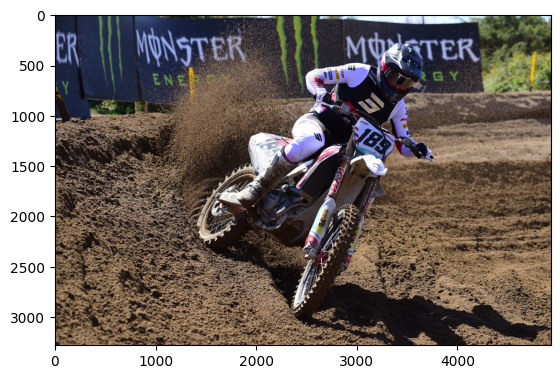

In [2]:
# We want to see if photos are in good quality

import matplotlib.pyplot as plt
import cv2

image = cv2.imread("/Users/noemiematrat/Library/CloudStorage/OneDrive-InfrontMotoRacing/PROJET_AUTOMATISATION/Train/BOGERS/BOGERS_MXGP_3_SAR_2024_MXGP_1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


## Preprocessing

In [3]:
# Resize images to the same size

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prétraitement et augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    "/Users/noemiematrat/Desktop/Projet_Zo/Train",
    target_size=(150, 150), batch_size=32, class_mode='categorical')


train_generator

2025-03-11 18:35:28.662322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 1124 images belonging to 27 classes.


In [4]:
# Preprocessing for Test Data (Normalization Only)
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data Generator
test_generator = test_datagen.flow_from_directory(
    '/Users/noemiematrat/Desktop/Projet_Zo/Test',   # Path to the test folder
    target_size=(150, 150),         # Images size
    batch_size=32,                  # Batch size
    class_mode='categorical',       # Multiclasse classification
    shuffle=False                   # No Data Shuffling for Evaluation
)


Found 389 images belonging to 27 classes.


In [5]:
import tensorflow as tf

def safe_generator(generator):
    for batch in generator:
        try:
            yield batch
        except OSError as e:
            print(f"Ignored Error on Batch : {e}")


## 1st Algorithm: CNN (very simple)

In [54]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model def
model = Sequential([
    # First convolution layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolution layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolution layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten layer
    Flatten(),
    Dropout(0.5),
    
    # Dense layer (fully connected)
    Dense(128, activation='relu'),
    Dense(27, activation='softmax')  # Number of class: 27 here
])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,835 (18.43 MB)

 Trainable params: 4,831,835 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(
    loss='categorical_crossentropy',  # Pour classification multiclasse
    optimizer='adam',  # Optimiseur adaptatif
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    safe_generator(train_generator),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    verbose=1
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.0816 - loss: 3.1621
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.0999 - loss: 3.0568
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.0731 - loss: 3.0838
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 243s 7s/step - accuracy: 0.0836 - loss: 3.0341
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.1259 - loss: 3.0081
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.1009 - loss: 2.9598
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.1155 - loss: 2.9054
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.1305 - loss: 2.9305
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.1369 - loss: 2.7704
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.1436 - loss: 2.7901
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.1767 - loss: 2.6748
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy:

In [58]:
# Test part
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size,
    verbose=1
)

print(f"Test Accuracy: {test_accuracy:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.0639 - loss: 4.2293
Test Accuracy: 0.11


Only 11% of the data can be explained, which is very low. Therefore, we need to find another model that is more effective for classification. The goal here is to achieve at least 0.5 as a value (client requirement).

## 2nd Algorithm: enhanced CNN

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Enhanced CNN creation
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),  # Reduces Overfitting

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(27, activation='softmax')  # 27 classes
])

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,731 (18.44 MB)

 Trainable params: 4,832,283 (18.43 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
model.compile(
    loss='categorical_crossentropy',  # Pour classification multiclasse
    optimizer='adam',  # Optimiseur adaptatif
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    safe_generator(train_generator),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    verbose=1
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.0440 - loss: 5.8814
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.0748 - loss: 3.3175
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - accuracy: 0.1033 - loss: 3.2674
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.1176 - loss: 3.2752
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.0856 - loss: 3.2529
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - accuracy: 0.0933 - loss: 3.2873
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.1015 - loss: 3.2297
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.0986 - loss: 3.2570
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.1033 - loss: 3.2108
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.1113 - loss: 3.1944
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.1140 - loss: 3.1839
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy:

In [11]:
# Test part
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size,
    verbose=1
)

print(f"Test Accuracy: {test_accuracy:.2f}")

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.0181 - loss: 3.1930
Test Accuracy: 0.05


## LDA Fisher (Latent Discriminant Analysis)

Found 1124 images belonging to 27 classes.
Found 389 images belonging to 27 classes.
✅ Train: (1124, 67500), Labels: (1124,)
✅ Test: (389, 67500), Labels: (389,)
🎯 Accuracy de LDA sur le test: 0.17

📊 Rapport de classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00         9
           2       0.63      0.70      0.66        56
           3       0.08      0.05      0.06        19
           4       0.08      0.05      0.06        20
           5       0.12      0.18      0.15        17
           6       0.10      0.16      0.12        25
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        24
          12       0.12      0.15      0.14        26
          13   

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

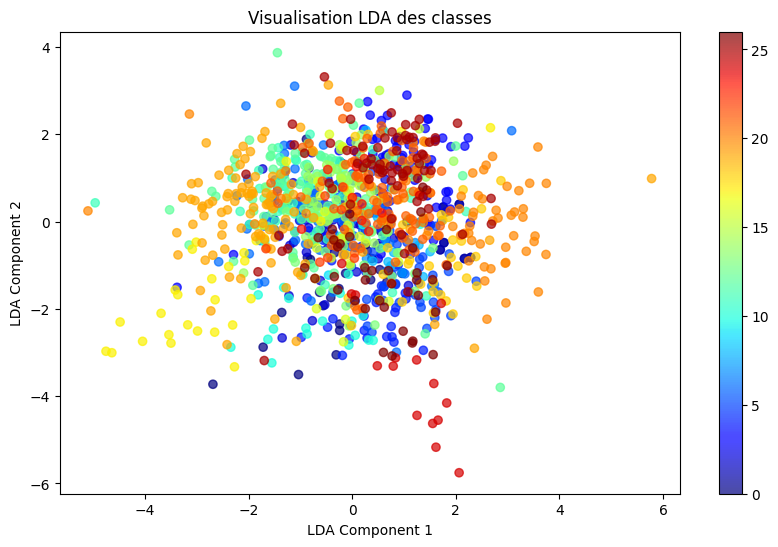

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# path for each dataset
train_path = "/Users/noemiematrat/Desktop/Projet_Zo/Train"
test_path = "/Users/noemiematrat/Desktop/Projet_Zo/Test"

# Images generator for data extract
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # to keep labels aligned
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # to compare with train
)

# Features extraction and labels
def extract_features(generator):
    X, y = [], []
    for i in range(len(generator)):
        batch = next(generator)
        images, labels = batch[0], batch[1]
        for img, label in zip(images, labels):
            X.append(img.flatten())  # Transform in vector
            y.append(np.argmax(label))  # Conversion one-hot in class index
    return np.array(X), np.array(y)

# Data extract
X_train, y_train = extract_features(train_generator)
X_test, y_test = extract_features(test_generator)

print(f"✅ Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"✅ Test: {X_test.shape}, Labels: {y_test.shape}")

# LDA (Fisher Latent discriminant analysis)
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)



# Prediction
y_pred = lda.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 LDA accuracy on test: {accuracy:.2f}")

print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))


## Test with SVM
We decided to retain the features obtained through LDA, as it is a dimensionality reduction technique. Therefore, we will attempt to enhance our LDA using an SVM (Support Vector Machine), which allows us to account for non-linear relationships between our latent vectors.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# SVM training with RBF Kernel
clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
clf.fit(X_train_lda, y_train)

X_test_lda = lda.transform(X_test)

# Prediction
y_pred = clf.predict(X_test_lda)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy after LDA + SVM: {accuracy:.2f}")
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))


🎯 Accuracy après LDA + SVM: 0.19

📊 Rapport de classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       1.00      0.11      0.20         9
           2       0.77      0.89      0.83        56
           3       0.00      0.00      0.00        19
           4       0.09      0.10      0.09        20
           5       0.05      0.12      0.07        17
           6       0.06      0.08      0.07        25
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        24
          12       0.06      0.08      0.07        26
          13       0.00      0.00      0.00        15
          14       0.08      0.16      0.10        19
          15       0.00      0.00      0.00         4
          16      

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

## LDA with Random Forest 
We decided to retain the features obtained through LDA, as it is a dimensionality reduction technique. Therefore, we will attempt to enhance our LDA using a Random Forest, which allows us to capture more complex relationships between our latent vectors.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model with 100 trees
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_lda, y_train)

# Prediction
y_pred = clf.predict(X_test_lda)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy after LDA + Random Forest: {accuracy:.2f}")
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))


🎯 Accuracy après LDA + Random Forest: 0.21

📊 Rapport de classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       1.00      0.11      0.20         9
           2       0.78      0.89      0.83        56
           3       0.10      0.11      0.10        19
           4       0.11      0.10      0.10        20
           5       0.15      0.18      0.16        17
           6       0.08      0.08      0.08        25
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        24
          12       0.14      0.12      0.13        26
          13       0.00      0.00      0.00        15
          14       0.05      0.05      0.05        19
          15       0.00      0.00      0.00         4
        

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

## PCA
Since LDA for dimensionality reduction does not seem to be the most effective, we will test a PCA (Principal Component Analysis). Then, we will reattempt using an SVM and a Random Forest for the classification of our images (which will be in the form of features).

### SVM

In [18]:
from sklearn.decomposition import PCA

# PCA (🔹 Réduction de dimension avec PCA (retain 95% of variance)
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# SVM model after PCA
clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after PCA + SVM: {accuracy:.2f}")
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))


Accuracy after PCA + SVM: 0.19

📊 Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       1.00      0.11      0.20         9
           2       0.44      0.91      0.59        56
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        20
           5       0.19      0.18      0.18        17
           6       0.09      0.16      0.11        25
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         1
          10       0.50      0.12      0.20         8
          11       0.00      0.00      0.00        24
          12       0.07      0.04      0.05        26
          13       0.00      0.00      0.00        15
          14       0.20      0.11      0.14        19
          15       0.00      0.00      0.00         4
          16       0.00 

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model with 100 trees
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Prediction
y_pred = clf.predict(X_test_pca)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after PCA + Random Forest: {accuracy:.2f}")
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))

Accuracy after PCA + Random Forest: 0.19

📊 Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       1.00      0.11      0.20         9
           2       0.98      0.89      0.93        56
           3       0.12      0.05      0.07        19
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        17
           6       0.02      0.04      0.03        25
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        24
          12       0.07      0.12      0.09        26
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         4
          16  

/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noemiematrat/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Projet Zo/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and b

# Test with CNN + ResNet (for amelioration)

ResNet is a pretrain model who can help my CNN to capture more informations of my dataset. 

In [20]:
pip install torch torchvision timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 76.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 9.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import timm  # For Vision Transformer (ViT)
import os

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")

# Data loading 
train_path = "/Users/noemiematrat/Desktop/Projet_Zo/Train"
test_path = "/Users/noemiematrat/Desktop/Projet_Zo/Test"

# Images transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard for ResNet/Vit
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Images loading with ImageFolder
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Classes number : {num_classes}")


Utilisation de : cpu
Classes number : 27


In [23]:
# CNN model
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Adjust Based on the Image
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Fine-Tuning ResNet18 
def get_resnet_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Vision Transformer (ViT)
def get_vit_model(num_classes):
    model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
    return model

# Train function
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Acc: {train_acc:.2f}%")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    print(f"Précision sur le test : {test_acc:.2f}%")



In [25]:
# Models execution
print("\nCNN training")
cnn_model = CNN_Model(num_classes)
train_model(cnn_model, train_loader, test_loader)

print("\nResNet18 training")
resnet_model = get_resnet_model(num_classes)
train_model(resnet_model, train_loader, test_loader)

print("\nVision Transformer (ViT) training")
vit_model = get_vit_model(num_classes)
train_model(vit_model, train_loader, test_loader)


CNN training
Epoch [1/10] - Loss: 128.7475 - Acc: 7.92%
Epoch [2/10] - Loss: 110.7659 - Acc: 8.10%
Epoch [3/10] - Loss: 108.2540 - Acc: 9.07%
Epoch [4/10] - Loss: 103.0429 - Acc: 14.32%
Epoch [5/10] - Loss: 96.3219 - Acc: 17.35%
Epoch [6/10] - Loss: 93.9687 - Acc: 17.97%
Epoch [7/10] - Loss: 89.5712 - Acc: 21.17%
Epoch [8/10] - Loss: 87.5212 - Acc: 22.51%
Epoch [9/10] - Loss: 83.5095 - Acc: 26.78%
Epoch [10/10] - Loss: 79.2398 - Acc: 29.09%
Précision sur le test : 12.34%

ResNet18 training


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/noemiematrat/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 31.6MB/s]


Epoch [1/10] - Loss: 93.3812 - Acc: 26.60%
Epoch [2/10] - Loss: 67.8253 - Acc: 40.39%
Epoch [3/10] - Loss: 52.9783 - Acc: 50.44%
Epoch [4/10] - Loss: 48.2682 - Acc: 56.14%
Epoch [5/10] - Loss: 39.5600 - Acc: 64.15%
Epoch [6/10] - Loss: 37.8253 - Acc: 66.99%
Epoch [7/10] - Loss: 31.8658 - Acc: 71.26%
Epoch [8/10] - Loss: 30.6279 - Acc: 71.80%
Epoch [9/10] - Loss: 25.4372 - Acc: 75.53%
Epoch [10/10] - Loss: 24.1772 - Acc: 79.18%
Précision sur le test : 28.53%

Vision Transformer (ViT) training
Epoch [1/10] - Loss: 130.6748 - Acc: 6.76%
Epoch [2/10] - Loss: 114.8998 - Acc: 8.10%
Epoch [3/10] - Loss: 114.0968 - Acc: 7.56%
Epoch [4/10] - Loss: 114.1490 - Acc: 8.45%
Epoch [5/10] - Loss: 112.2274 - Acc: 8.27%
Epoch [6/10] - Loss: 110.9274 - Acc: 8.90%
Epoch [7/10] - Loss: 110.6115 - Acc: 8.19%
Epoch [8/10] - Loss: 109.1952 - Acc: 8.99%
Epoch [9/10] - Loss: 108.6212 - Acc: 9.07%
Epoch [10/10] - Loss: 108.6250 - Acc: 10.05%
Précision sur le test : 5.91%
